In [17]:
import yfinance as yf
from backtesting import Backtest, Strategy
import pandas as pd
import pandas_ta as ta
from datetime import datetime
import time
from tqdm import tqdm
tqdm.pandas()

In [25]:
stocks = ["AAPL", "META", "TSLA", "AMZN", "TSLA", "NVDA", "GE"]
BACKCANDLES = 7
period = {
    "start": "2020-01-01",
    "end": "2025-01-01",
    "period": "1d"
}


In [29]:
def fetch_data(stocks, period: dict):
    start = period.get("start", "2020-01-01")
    end = period.get("end", datetime.now())
    interval = period.get("period", "1d")
    dataframes = []

    for stock in stocks:
        tmp = yf.Ticker(stock).history(start=start, end=end, interval="1d")
        dataframes.append(tmp)
        time.sleep(0.5)

    return dataframes, stocks

def apply_indicators(df: pd.DataFrame, ema_slow: int = 200, ema_fast: int = 100, rsi_len: int = 14, band_len: int = 20, band_std: float = 2.0, atr_p = 10):
    df["EMA_S"] = ta.ema(df.Close, length=ema_slow)
    df["EMA_F"] = ta.ema(df.Close, length=ema_fast) 

    df["RSI"] = ta.rsi(df.Close, length=rsi_len)
    df["ATR"] = ta.atr(df.High, df.Low, df.Close, length=atr_p)

    bbands = ta.bbands(df.Close, std=band_std, length=band_len)
    df = df.join(bbands)
    return df

def signal(df, curr_candle, backcandles):
    df_slice = df.reset_index().copy()
    start = max(0, curr_candle - backcandles)
    end = curr_candle

    rel_rows = df_slice.iloc[start:end]

    if all(rel_rows["EMA_F"] < rel_rows["EMA_S"]):
        return 1
    elif all(rel_rows["EMA_F"] > rel_rows["EMA_S"]):
        return 2
    else:
        return 0
    
def update_df_ema_signal(df):
    df.reset_index(inplace=True)
    df["EMA_SIG"] = df.progress_apply(lambda row: signal(df, row.name, BACKCANDLES) \
                                       if row.name >= 20 else 0, axis=1)
    return df

def total_signal(df, curr_candle, 
                 backcandles, band_len: int = 20, 
                 band_std: float = 2.0, threshold=0.0015):
    
    bbl = df[f"BBL_{band_len}_{band_std}"][curr_candle] 
    bbu = df[f"BBU_{band_len}_{band_std}"][curr_candle]

    c_BB_width = (abs(bbl - bbu) / bbl) > threshold

    if (signal(df, curr_candle=curr_candle, backcandles=backcandles)==2
        and df.Close[curr_candle] <= bbl
        and c_BB_width
        and all(df.iloc[curr_candle-backcandles:curr_candle]["RSI"]>=30)):
        
        return 2
    elif (signal(df, curr_candle=curr_candle, backcandles=backcandles)==2
        and df.Close[curr_candle] <= bbu
        and c_BB_width
        and all(df.iloc[curr_candle-backcandles:curr_candle]["RSI"]<=70)):

        return 2
    
    return 0

def update_df_total_signal(df):
    df.reset_index(inplace=True)
    df["TOTAL_SIG"] = df.progress_apply(lambda row: total_signal(df, row.name, BACKCANDLES), axis=1)
    return df


def candles_trend_signal(df, current_candle, backcandles):

    bullish = True
    bearish = True

    for i in range(current_candle - backcandles, current_candle+1):
        if i < 0:
            return 0  
        
        if df.High[i] <= df['EMA_F'][i] or df.Low[i] <= df['EMA_F'][i]:
            bullish = False
        
        if df.High[i] >= df['EMA_F'][i] or df.Low[i] >= df['EMA_F'][i]:
            bearish = False

    if bullish:
        return 2
    if bearish:
        return 1
    return 0

def update_total_signal(df, backcandles=5):
    df['candle_trend_signal'] = [candles_trend_signal(df, x, backcandles=backcandles) if x >= backcandles else 0 for x in tqdm(df.index)]
    df['TOTAL_SIG'] = df.apply(lambda row: row['TOTAL_SIG'] if row['TOTAL_SIG'] == row['candle_trend_signal'] else 0, axis=1)
    return df

In [30]:

dataframes, stocks = fetch_data(stocks, period)

for i, df in enumerate(dataframes):
    print(stocks[i])
    df = apply_indicators(df)
    df = update_df_ema_signal(df)
    df = update_df_total_signal(df)
    df = update_total_signal(df)
    dataframes[i] = df

AAPL


100%|██████████| 1258/1258 [00:00<00:00, 6374.15it/s]


META


100%|██████████| 1258/1258 [00:00<00:00, 6389.48it/s]


TSLA


100%|██████████| 1258/1258 [00:00<00:00, 6377.85it/s]


AMZN


100%|██████████| 1258/1258 [00:00<00:00, 6401.69it/s]


TSLA


100%|██████████| 1258/1258 [00:00<00:00, 6385.85it/s]


NVDA


100%|██████████| 1258/1258 [00:00<00:00, 6446.68it/s]


GE


100%|██████████| 1258/1258 [00:00<00:00, 6431.44it/s]


In [34]:
import numpy as np
def SIGNAL():
    return df.TOTAL_SIG

class MultiAssetMR(Strategy):
    pos_size = 0.1
    slcoef = 1
    
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        
        for trade in self.trades: 
            if trade.is_long: 
                trade.sl = max(trade.sl or -np.inf, self.data.Close[-1] - slatr)
            else:
                trade.sl = min(trade.sl or np.inf, self.data.Close[-1] + slatr) 

        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            self.buy(sl=sl1, size=self.pos_size)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            self.sell(sl=sl1, size=self.pos_size)

In [35]:
results = []

for df in dataframes:
    bt = Backtest(df, MultiAssetMR, cash=5000, margin=0.5, commission=0.0002)
    stats, heatmap = bt.optimize(
        slcoef=[i/10 for i in range(8, 31)],
        pos_size = [i/100 for i in range(8, 31)],
        maximize='Return [%]', max_tries=3000,
        random_state=0,
        return_heatmap=True)
    results.append(stats)

C:\Users\admin\AppData\Local\Temp\ipykernel_20696\1005435790.py:4: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MultiAssetMR, cash=5000, margin=0.5, commission=0.0002)
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\backtesting\backtesting.py:1592: UserWarning: Searching for best of 529 configurations.
  output = _optimize_grid()
C:\Users\admin\AppData\Local\Temp\ipykernel_20696\1005435790.py:4: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MultiAssetMR, cash=5000, margin=0.5, commission=0.0002)
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\backtesting\backtesting.py:1592: UserWarning: Searching for best of 529 configurations.
  output = _optimize_grid()
C:\Users\admin\AppData\Local\Temp\ipykernel_20696\1005435790.py:4: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` 

In [36]:
agg_returns = sum([r["Return [%]"] for r in results])
num_trades = sum([r["# Trades"] for r in results])
max_drawdown = min([r["Max. Drawdown [%]"] for r in results])
avg_drawdown = sum([r["Avg. Drawdown [%]"] for r in results]) / len(results)

win_rate = sum([r["Win Rate [%]"] for r in results]) / len(results)
best_trade = max([r["Best Trade [%]"] for r in results])
worst_trade = min([r["Worst Trade [%]"] for r in results])
avg_trade = sum([r["Avg. Trade [%]"] for r in results]) / len(results)
max_trade_duration = max([r["Max. Trade Duration"] for r in results])
avg_trade_duration = sum([r["Avg. Trade Duration"] for r in results]) / len(results)

print(f"Aggregated Returns: {agg_returns:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Average Drawdown: {avg_drawdown:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Best Trade: {best_trade:.2f}%")
print(f"Worst Trade: {worst_trade:.2f}%")
print(f"Average Trade: {avg_trade:.2f}%")
print(f"Maximum Trade Duration: {max_trade_duration} days")
print(f"Average Trade Duration: {avg_trade_duration:.2f} days")


Aggregated Returns: 411.94%
Number of Trades: 151.0
Maximum Drawdown: -36.73%
Average Drawdown: -5.06%
Win Rate: 45.46%
Best Trade: 91.08%
Worst Trade: -20.77%
Average Trade: 3.26%
Maximum Trade Duration: 108.0 days
Average Trade Duration: 23.36 days


In [37]:
equity_curves = [stats['_equity_curve']['Equity'] for stats in results]
max_length = max(len(equity) for equity in equity_curves)

# Pad each equity curve with the last value to match the maximum length
padded_equity_curves = []
for equity in equity_curves:
    last_value = equity.iloc[-1]
    padding = [last_value] * (max_length - len(equity))
    padded_equity = equity.tolist() + padding
    padded_equity_curves.append(padded_equity)

equity_df = pd.DataFrame(padded_equity_curves).T

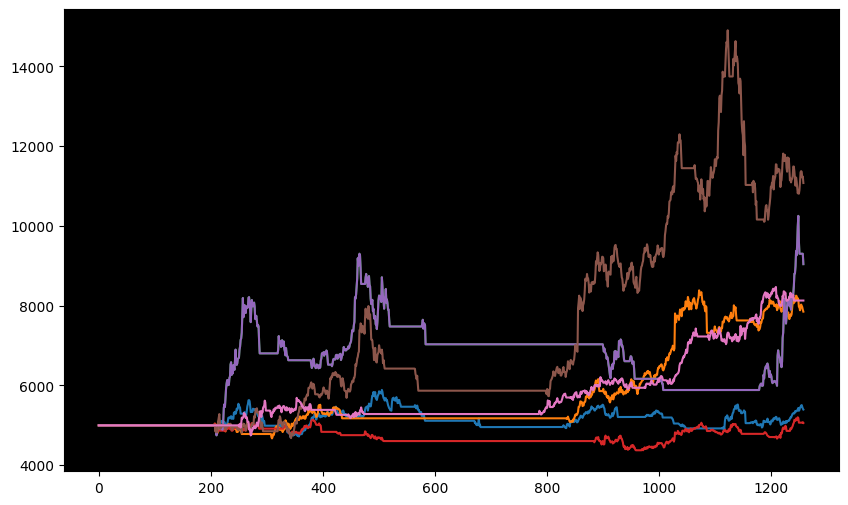

In [38]:
import matplotlib.pyplot as plt

equity_df.plot(kind='line', figsize=(10, 6), legend=False).set_facecolor('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.gca().set_facecolor('black')